# Lineær regression - Kan vi estimere antallet af linjer

- **Problem:** Kan jeg med ML estimere antallet af linjer en FED overskrift giver anledning til? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et lineært problem
- **Succes er** Jeg vil undersøge om en simpel model kan finde sammenhængen. Jeg håber på det bedste, men er skeptisk, for jeg kan ikke selv se et klart mønster ...
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data?
- **Optimering vs generalisering** Den får vi se på ...
- **Tuning hyper pametre** Den får vi se på ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)

### Konklusion
1. forsøg: Jeg har nok 'Imbalanced Classes', så algoritmen har alt at vinde ved altid at gætte på 1?

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FED_test.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 15000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [3]:
# TOKENIZER - laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Fandt %s unikke tokens.' % len(word_index))

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Fandt 10426 unikke tokens.


In [4]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
NumLines_train = np.asarray(NumLines_train).astype('float32')
NumLines_test = np.asarray(NumLines_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(NumLines_train.shape)
print(NumLines_test.shape)

(15000, 10000)
(6148, 10000)
(15000,)
(6148,)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 10
history = model.fit(data_train, NumLines_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/10
12000/12000 [==============================] - 4s 324us/step - loss: 125.6366 - mean_absolute_error: 7.4148 - val_loss: 132.7383 - val_mean_absolute_error: 7.4043
Epoch 2/10
12000/12000 [==============================] - 2s 128us/step - loss: 123.6734 - mean_absolute_error: 7.2831 - val_loss: 130.7283 - val_mean_absolute_error: 7.2701
Epoch 3/10
12000/12000 [==============================] - 2s 125us/step - loss: 122.1602 - mean_absolute_error: 7.1774 - val_loss: 129.3625 - val_mean_absolute_error: 7.1741
Epoch 4/10
12000/12000 [==============================] - 1s 124us/step - loss: 121.1389 - mean_absolute_error: 7.1034 - val_loss: 128.6008 - val_mean_absolute_error: 7.1181
Epoch 5/10
12000/12000 [==============================] - 1s 124us/step - loss: 120.4547 - mean_absolute_error: 7.0577 - val_loss: 128.2045 - val_mean_absolute_error: 7.0876
Epoch 6/10
12000/12000 [==============================] - 1s 120us/step - loss: 1

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

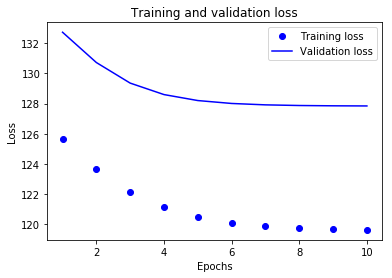

In [9]:
# plotter historikken for 'loss'
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

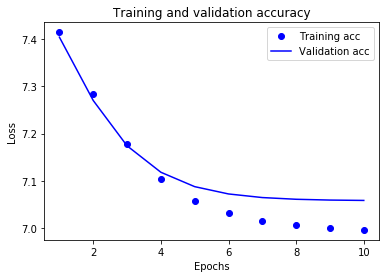

In [10]:
# plotter historikken for mae
plt.clf()   # clear figure

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']


#acc_values = history_dict['acc']
#val_acc_values = history_dict['val_acc']

plt.plot(epochs, mae, 'bo', label='Training acc')
plt.plot(epochs, val_mae, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# vi prøver modellen på test-data

predictions = model.predict(data_test)

for i in range(1,100):
    print(('%1.4f' % predictions[i]))

1.0000
0.9997
1.0000
1.0000
0.9999
1.0000
1.0000
0.9994
1.0000
1.0000
1.0000
0.9999
1.0000
1.0000
0.9997
1.0000
1.0000
0.9996
1.0000
1.0000
1.0000
1.0000
0.9961
0.9991
1.0000
0.9961
1.0000
0.9996
0.9997
1.0000
0.9995
1.0000
0.9986
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
0.9943
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
0.9994
0.9962
1.0000
0.9997
1.0000
0.9968
1.0000
0.9914
1.0000
1.0000
0.9996
1.0000
0.9961
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
0.9991
1.0000
0.9998
0.9999
1.0000
0.9996
1.0000
1.0000
1.0000
0.9962
0.9998
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
0.9994
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
0.9975
1.0000
1.0000
0.9999
1.0000


In [ ]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.4 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

In [ ]:
# Gennemsnittet for rigtig og forkert

print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

In [ ]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

print('Jeg printer nogle liner som er sande i test data:')
for i in range(1,300):
    if labels_test[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

In [ ]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

UHA UHA, alt for mange af de sande har en værdi tæt på 0 ...

### Modellen er ikke specielt præcis. jeg checker lige efter på træninsdata, dem kan man håbe den har lært bedre at kende???

In [ ]:
# vi prøver modellen på test-data

predictions = model.predict(data_train)

# print de første predictions
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

In [ ]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_train))
NumEstimated = 0
for i in range(1,len(labels_train)):
    if predictions[i]>0.4 and labels_train[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_train)*100), '%')

In [ ]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er RIGTIGE (store)

print('Nogle linjer som er SANDE i train data:')
for i in range(1,300):
    if labels_train[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

In [ ]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er FORKERTE (små)

print('Nogle linjer som er FALSKE i train data:')
for i in range(1,200):
    if labels[i]==0:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

In [ ]:
# finder gennemsnittet for dem som er rigtige og forkerte

print(' Gennemsnit for ttrain stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels[i]]))

In [ ]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_train[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_train[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store train')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små train')
plt.legend(loc='upper right')
plt.ylim([0, 1000])

plt.show()

In [ ]:
# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]